<center><h1>Example of statistical analysis:</h1>
<h2>Search of gaussian signal in an exponentially decreasing background</h2> 

<h3>1. Tools and functions definitions: </h3>

<h4> loading the tools: </h4>

In [40]:
# Native Python modules
import os, sys, csv, string, math

# Scipy/Numpy modules
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
#get the plots in the notebook

%pylab inline

# IPython magic: recharge automatique des modules qui auraient été modifiés
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h4>Functions definitions </h4>

In [41]:
def expBgFunc(beta):
    return lambda x: 1.0/beta*np.exp(-x/beta)
def linBgFunc(constant, slope):
    return lambda x: constant+slope*x
def sigFunc(mu, sigma):
    return lambda x: 1.0/(np.sqrt(2*np.pi)*sigma)*np.exp(-np.power((x-mu),2)/(2*np.power(sigma,2)))

In [42]:
ebg=expBgFunc(15)
s=(-0.1)
lbg=linBgFunc(20,s)
sg=sigFunc(125,2)

<h4>generate the signal and background histograms</h4>

In [43]:
def generateHisto(xRange,nbBins,func):
    binSize=(xRange[1]-xRange[0])/nbBins
    xBinLow=[]
    xiVal=[]
    xWidth=[]
    #first check which scale should be applied to the histogram
    histoIntegral=0
    for i in range(0,nbBins):
        xi=xRange[0]+1.0*i*binSize+1.0*binSize/2
        histoIntegral=histoIntegral+func(xi)
    #compute the scale to apply to the histo
    reScale=1./histoIntegral
    #now generate the histo
    for i in range(0,nbBins):
        xBinLow.append(xRange[0]+i*binSize)
        xi=xRange[0]+1.0*i*binSize+1.0*binSize/2
        #print (func(xi))
        #print (reScale*func(xi))
        xiVal.append(reScale*func(xi))
        xWidth.append(binSize)
    return [xBinLow, xiVal, xWidth]



sumSig= 1.0 sumEBg= 1.0 sumLBg= 1.0


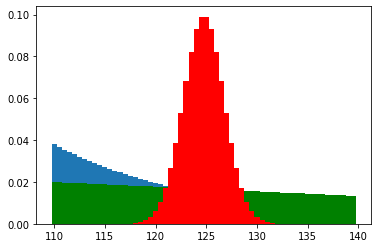

In [44]:
ebgHisto_=generateHisto([110,140],60,ebg)
lbgHisto_=generateHisto([110,140],60,lbg)
sigHisto_=generateHisto([110,140],60,sg)
 
plt.bar(ebgHisto_[0], ebgHisto_[1], width=ebgHisto_[2])     
plt.bar(lbgHisto_[0], lbgHisto_[1], width=lbgHisto_[2],color='g')     
plt.bar(sigHisto_[0], sigHisto_[1], width=sigHisto_[2],color='r')     

print('sumSig=',sum(sigHisto_[1]), 'sumEBg=', sum(ebgHisto_[1]), 'sumLBg=', sum(lbgHisto_[1]))



<BarContainer object of 60 artists>

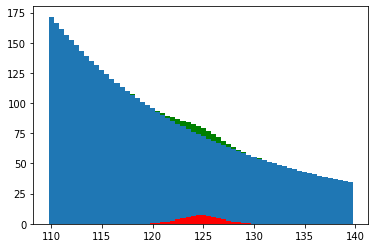

In [54]:
NbEbgEvent_=4000
NbLbgEvent_=1000
NbSigEvent_=70

sigHistoNormedToXS=[x * NbSigEvent_ for x in sigHisto_[1]]
ebgHistoNormedToXS=[x * NbEbgEvent_ for x in ebgHisto_[1]]
lbgHistoNormedToXS=[x * NbLbgEvent_ for x in lbgHisto_[1]]

sumBg=list(map(add, lbgHistoNormedToXS, ebgHistoNormedToXS))
sumSigBg=list(map(add, sumBg, sigHistoNormedToXS))
plt.bar(sigHisto_[0], sumSigBg, width=sigHisto_[2],color='g')     
plt.bar(sigHisto_[0], sumBg, width=sigHisto_[2])     
plt.bar(sigHisto_[0], sigHistoNormedToXS, width=sigHisto_[2],color='r')

<h4>Generate pseudo-data</h4>

<BarContainer object of 60 artists>

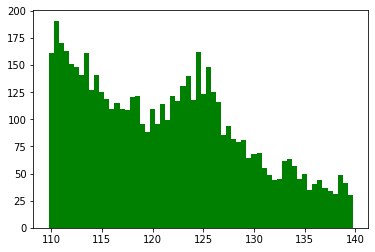

In [86]:
def pseudoDataFromHisto(sig, sigStrength, ebg, ebgStrength, lbg, lbgStrength):
    pseudoDataHisto=[]
    sH=[x * sigStrength for x in sig]
    ebH=[x * ebgStrength for x in ebg]
    lbH=[x * lbgStrength for x in lbg]
    theHisto=map(add, sH, ebH)
    theHisto=map(add, theHisto, lbH)
    for aBin in theHisto:
        pseudoDataHisto.append(np.random.poisson(aBin,1)[0])
    return pseudoDataHisto

sst = 10
est = 1
lst = 1

myPseudoDataTest=pseudoDataFromHisto(sigHistoNormedToXS, sst, 
                                     ebgHistoNormedToXS, est, 
                                     lbgHistoNormedToXS, lst)
data=myPseudoDataTest
plt.bar(sigHisto_[0], data, width=sigHisto_[2],color='g')  


<h4>Define and compute -2 x the negative log-likelihood</h4>

In the formulas below, a single parameter, the signal strength $\kappa$, is left free.

$$L_{\kappa \times s + b}(data) = \prod_{i \in bins} P_{Poisson}\left(d_{i} | \kappa \times s_{i} + b_{i}\right) $$
$$L_{\kappa \times s + b}(data) = \prod_{i \in bins} \frac{\left(\kappa \times s_{i} + b_{i}\right)^{d_{i}}}{d_{i}!}\times e^{-\left(\kappa \times s_{i} + b_{i}\right)} $$
$$-2 \ln L_{\kappa \times s + b}(data) = -2 \times \sum_{i \in bins} \left[ -\ln(d_i !) +d_i \ln(\kappa \times s_i + b_i) - \kappa \times s_i - b_i \right]$$


The term $\sum \ln(d_i!)$ can conveniently be omitted, since the minimization for $\kappa$ is not affected and since this term would quickly become numerically huge and make the numerical calculation fail.

$$ \frac{\partial}{\partial \kappa} \left(−2\ln L_{\kappa \times s + b}(data) \right)=-2 \sum_{i} \left[ \frac{d_i . s_i}{\kappa s_i + b_i}  - s_i \right]$$
$$ = 0 for \sum_{i} \left[ \frac{d_i}{\kappa s_i + b_i}  - 1 \right] = 0$$

<h4>-2.nll with the strengths of the signal and both backgrounds as parameters</h4>

In [87]:
def minusTwoTimesLogLik(data, sig, ebg, lbg, args):
    di = np.array(data)
    si = np.array(sig)
    ei = np.array(ebg)
    li = np.array(lbg)
    logArg = args[0]*si + args[1]*ei + args[2]*li
    #protection contre les log d'argument négatif ou nul... 
    #peut causer des discontinuités dans la fonction de vraisemblance; à vérifier
    xi = di * np.log(logArg, out=logArg, where=logArg > 0) - args[0]*si - args[1]*ei - args[2]*li
    return -2*np.sum(xi)

In [88]:
print("pseudo-data input values for sst, est, lst:", sst, est, lst)
print("-2.nll value:", minusTwoTimesLogLik(data, sigHistoNormedToXS, ebgHistoNormedToXS, lbgHistoNormedToXS, (sst, est, lst)))
di = np.array(data)
si = np.array(sigHistoNormedToXS)
ei = np.array(ebgHistoNormedToXS)
li = np.array(lbgHistoNormedToXS)


pseudo-data input values for sst, est, lst: 10 1 1
-2.nll value: -42754.779036994325


<h4>-2.nll with the strength of the signal left free and both backgrounds supposed known</h4>

In [89]:
def mTllForSignalScan(data, sig, ebg, lbg, sst, est, lst):
    return lambda sst:minusTwoTimesLogLik(data, sig, ebg, lbg, (sst, est,lst))

mTll  

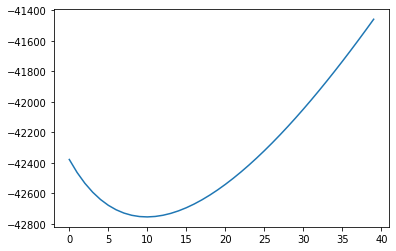

In [94]:
x=5
scan=mTllForSignalScan(data, 
                        sigHistoNormedToXS,
                                                ebgHistoNormedToXS,
                                                lbgHistoNormedToXS,
                                                x, est, lst)
fn=generateHisto([0,40],10,scan)
x = np.arange(0,40)
plt.plot(x, [scan(c) for c in x])
  
#plt.bar(fn[0], fn[1], width=fn[2])  
#plt.yscale("log")


In [91]:
[scan(c) for c in range(0,40)]

[-42378.25522016012,
 -42463.53657057664,
 -42534.49918583431,
 -42593.03001924057,
 -42640.65246692276,
 -42678.615900220604,
 -42707.95891817069,
 -42729.555134139824,
 -42744.14702573671,
 -42752.37142623732,
 -42754.779036994325,
 -42751.84958143226,
 -42744.00372804758,
 -42731.61258174567,
 -42715.00531997643,
 -42694.475395856374,
 -42670.28562183905,
 -42642.67236981284,
 -42611.84906715994,
 -42578.009126904,
 -42541.3284192804,
 -42501.96736890663,
 -42460.07274413639,
 -42415.77919168639,
 -42369.21055918111,
 -42320.48104011038,
 -42269.696169285875,
 -42216.953691803574,
 -42162.34432446978,
 -42105.95242539541,
 -42047.85658483604,
 -41988.13014822163,
 -41926.84168057515,
 -41864.05538008791,
 -41799.83144743783,
 -41734.22641645662,
 -41667.2934509368,
 -41599.08261168593,
 -41529.64109736334,
 -41459.013462151124]

In [92]:
fit_res = optimize.minimize(lambda args:minusTwoTimesLogLik(data,
                                                             sigHistoNormedToXS,
                                                             ebgHistoNormedToXS,
                                                             lbgHistoNormedToXS,
                                                             tuple(args)),
                             (sst,est,lst),
                             tol=0.001,
                             bounds=((0,100),(0,100),(0,100)))
print('succès: ',fit_res['success'], 'cause:', fit_res['message'])
fit = fit_res['x']
print("Résultat de l'ajustement par max. vraisemblance: ")
print("sst,est,lst=",fit)
nnl2 = fit_res['fun']
print("-2.nll value:",nnl2)

                             

succès:  True cause: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Résultat de l'ajustement par max. vraisemblance: 
sst,est,lst= [9.99989382 1.03134047 1.01906508]
-2.nll value: -42758.0622996807


<h4>Distribution of the strength estimators from pseudo-experiments</h4>

vraies valeurs:[ 5 1 1 ]


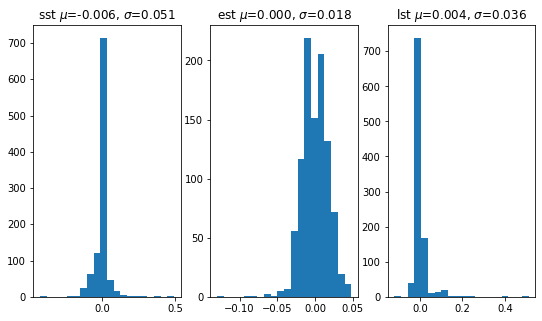

In [13]:
nexp = 1000
exp_fits = []
kfit = (sst,est,lst)

for i in range(0,nexp):
    data = pseudoDataFromHisto(sigHistoNormedToXS, sst, 
                               ebgHistoNormedToXS, est, 
                               lbgHistoNormedToXS, lst)
    fit_res = optimize.minimize(lambda args:minusTwoTimesLogLik(data, 
                                                                sigHistoNormedToXS,
                                                                ebgHistoNormedToXS,
                                                                lbgHistoNormedToXS,
                                                                tuple(args)),
                                (sst,est,lst),
                                tol=0.001,
                                bounds=((0,100),(0,100),(0,100)))
#print('succès: ',fit_res['success'], 'cause:', fit_res['message'])
    exp_fits.append(fit_res['x'])
    
parameter_names = ['sst','est','lst']
# 
for i in range(3):
    plt.subplot(1,3,i+1)
    delta_i = (np.array(exp_fits)[:,i] - kfit[i])
    plt.hist(delta_i,bins=20)
    rms_i =  np.sqrt(delta_i.var())
    bias_i = delta_i.mean()
    plt.title(r'%s $\mu$=%.3f, $\sigma$=%.3f'%(parameter_names[i],bias_i, rms_i))
plt.gcf().set_size_inches(9,5)

print('vraies valeurs:[',kfit[0],kfit[1],kfit[2],']')


In [14]:
def minusTwoTimesLogLikNoExp(data, sig, lbg, args):
    di = np.array(data)
    si = np.array(sig)
    li = np.array(lbg)
    logArg = args[0]*si + + args[1]*li
    xi = di * np.log(logArg, out=logArg, where=logArg > 0) - args[0]*si - args[1]*li
    return -2*np.sum(xi)

vraies valeurs:[ 5 1 ]


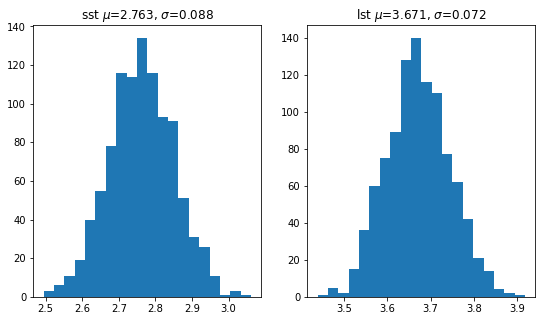

In [15]:
nexp = 1000
exp_fits = []
kfit2 = (sst,lst)

for i in range(0,nexp):
    data = pseudoDataFromHisto(sigHistoNormedToXS, sst, 
                               ebgHistoNormedToXS, est, 
                               lbgHistoNormedToXS, lst)
    fit_res = optimize.minimize(lambda args:minusTwoTimesLogLikNoExp(data, 
                                                                    sigHistoNormedToXS,
                                                                    lbgHistoNormedToXS,
                                                                    tuple(args)),
                                (sst,lst),
                                tol=0.001, 
                                bounds=((0,100),(0,100)))
#print('succès: ',fit_res['success'], 'cause:', fit_res['message'])
    exp_fits.append(fit_res['x'])
    
parameter_names = ['sst','lst']
# 
for i in range(2):
    plt.subplot(1,2,i+1)
    delta_i = (np.array(exp_fits)[:,i] - kfit2[i])
    plt.hist(delta_i,bins=20)
    rms_i =  np.sqrt(delta_i.var())
    bias_i = delta_i.mean()
    plt.title(r'%s $\mu$=%.3f, $\sigma$=%.3f'%(parameter_names[i],bias_i, rms_i))
plt.gcf().set_size_inches(9,5)

print('vraies valeurs:[',kfit2[0],kfit2[1],']')
